# Compartmentalization via eigendecomposition

In [18]:
%matplotlib inline
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.style.use('seaborn-white')

import multiprocess as mp
import numpy as np
import pandas as pd
import bioframe
import cooltools
import cooler

In [5]:
mm9 = bioframe.fetch_chromsizes('mm9')
chromsizes = bioframe.fetch_chromsizes('mm9')
chromosomes = list(chromsizes.index)

In [46]:
conditions = ['WT', 'T', 'dN']
binsize = 100000

cooler_paths = {    
    'WT' : f'data/UNTR.{binsize}.cool',
    'T'  : f'data/TAM.{binsize}.cool',
    'dN' : f'data/NIPBL.{binsize}.cool',
}
long_names = {
    'WT': 'Wildtype',
    'T' : 'TAM',
    'dN': 'NipblKO',
}
pal = sns.color_palette('colorblind')
colors = {
    'WT': pal[0],
    'T' : '#333333',
    'dN': pal[2],
}

clrs = {
    cond: cooler.Cooler(cooler_paths[cond]) for cond in conditions
}

## Get binned GC-content (proxy for the "A" phase)

In [7]:
bins = cooler.binnify(mm9, binsize)
fasta_records = bioframe.load_fasta('data/mm9.fa')
bins['GC'] = bioframe.tools.frac_gc(bins, fasta_records)
bins.head()

,chrom,start,end,GC
0,chr1,0,100000,NaN
1,chr1,100000,200000,NaN
2,chr1,200000,300000,NaN
3,chr1,300000,400000,NaN
4,chr1,400000,500000,NaN


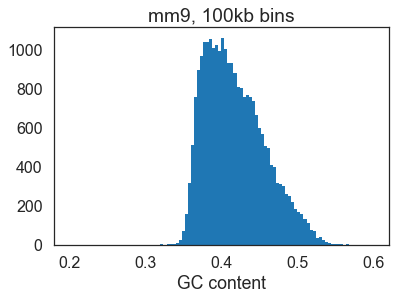

In [19]:
_=plt.hist(bins['GC'].dropna(), range=(0.2, 0.6), bins=100)
plt.xlabel('GC content')
plt.title(f'mm9, {binsize//1000}kb bins')

## Compute eigenvectors

In [14]:
from cooltools.eigdecomp import cooler_cis_eig

lam = {}
eigs = {}

for cond in conditions:
    lam[cond], eigs[cond] = cooler_cis_eig(
        clrs[cond], 
        bins,
        n_eigs=3, 
        phasing_track_col='GC', 
        sort_metric='var_explained')
    
    # Save text files
    lam[cond].to_csv(f'data/{long_names[cond]}.{binsize//1000}kb.eigs.cis.lam.txt', sep='\t')
    eigs[cond].to_csv(f'data/{long_names[cond]}.{binsize//1000}kb.eigs.cis.vecs.txt', sep='\t', index=False)
    
    # Save bigwig track
    bioframe.to_bigwig(eigs[cond], mm9, f'data/{long_names[cond]}.{binsize//1000}kb.eigs.cis.vecs.E1.bw', 'E1')

bedGraphToBigWig /tmp/tmpcmjomjws.bg /tmp/tmp1wlrexbp.chrom.sizes data/Wildtype.100kb.eigs.cis.vecs.E1.bw
bedGraphToBigWig /tmp/tmpzka5c5m1.bg /tmp/tmpxg4syjxs.chrom.sizes data/NipblKO.100kb.eigs.cis.vecs.E1.bw


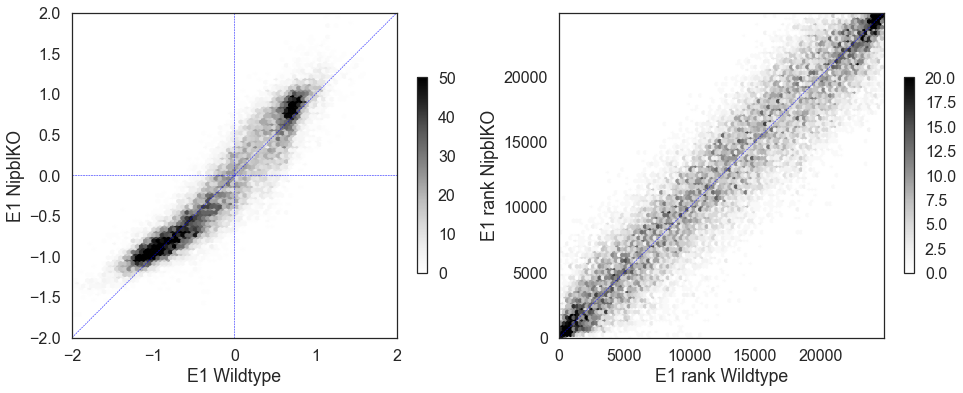

In [36]:
gs = plt.GridSpec(nrows=1, ncols=2)
plt.figure(figsize=(16, 6))
condx, condy = 'WT', 'dN'

plt.subplot(gs[0])
lo, hi = -2 , 2
plt.hexbin(
    eigs[condx]['E1'],
    eigs[condy]['E1'],
    vmax=50,
)
plt.xlabel('E1 ' + long_names[condx])
plt.ylabel('E1 ' + long_names[condy])
plt.gca().set_aspect(1)
plt.xlim(lo, hi)
plt.ylim(lo, hi)
plt.axvline(0, c='b', lw=0.5, ls='--')
plt.axhline(0, c='b', lw=0.5, ls='--')
plt.plot([lo, hi], [lo, hi], c='b', lw=0.5, ls='--')
plt.colorbar(shrink=0.6)


plt.subplot(gs[1])
mask = eigs[condx]['E1'].notnull() & eigs[condy]['E1'].notnull() 
vx = eigs[condx]['E1'].loc[mask].values
vy = eigs[condy]['E1'].loc[mask].values
lo, hi = 0 , len(vx)

plt.hexbin(
    rankdata(vx),
    rankdata(vy),
    vmax=20,
)
plt.xlabel('E1 rank ' + long_names[condx])
plt.ylabel('E1 rank ' + long_names[condy])
plt.gca().set_aspect(1)
plt.xlim(lo, hi)
plt.ylim(lo, hi)
plt.plot([lo, hi], [lo, hi], c='b', lw=0.5, ls='--')
plt.colorbar(shrink=0.6)

## The "saddle" plot

/net/proteome/home/nezar/local/devel/cooltools/cooltools/saddle.py:109: RuntimeWarning: invalid value encountered in true_divide
  toeplitz(expected[chrom])
/home/nezar/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide
/home/nezar/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in log10


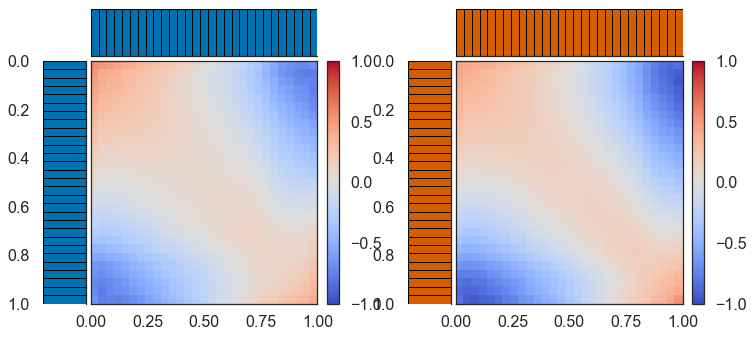

In [42]:
from cooltools import saddle

QUANTILE_BINNING = True

binedges = {}
digitized = {}
hist = {}
sums = {}
counts = {}
saddledata = {}

gs = plt.GridSpec(nrows=1, ncols=2)
fig = plt.figure(figsize=(12, 6))
histbins = 30

for i, cond in enumerate(conditions):
    exp = pd.read_table(f'data/{long_names[cond]}.{binsize//1000}kb.expected.cis.tsv')
    eig = pd.read_table(f'data/{long_names[cond]}.{binsize//1000}kb.eigs.cis.vecs.txt')

    # Determine how to bin the range of the E1 signal
    if QUANTILE_BINNING:
        q_binedges = np.linspace(0, 1, histbins)
        binedges[cond] = saddle.quantile(eig['E1'], q_binedges)
    else:
        qlo, qhi = saddle.quantile(eig['E1'], [0.02, 0.98])  # trim outliers
        binedges[cond] = np.linspace(qlo, qhi, histbins)

    # Digitize the signal into integers
    digitized[cond], hist[cond] = saddle.digitize_track(
        binedges[cond], 
        track=(eig, 'E1'))
    
    # Construct a function that fetches and calculates observed/expected
    getmatrix = saddle.make_cis_obsexp_fetcher(clrs[cond], (exp, 'balanced.avg'))
    
    # Build the saddle histogram
    sums[cond], counts[cond] = saddle.make_saddle(
        getmatrix, 
        binedges[cond],
        (digitized[cond], 'E1.d'), 
        contact_type='cis')
    saddledata[cond] = sums[cond] / counts[cond]
    
    # Make the saddle plot
    g = saddle.saddleplot(
        q_binedges if QUANTILE_BINNING else binedges[cond],
        hist[cond], 
        np.log10(saddledata[cond]), 
        color=colors[cond],
        heatmap_kws={'vmin': -1, 'vmax': 1}, 
        fig=fig, subplot_spec=gs[i])

/net/proteome/home/nezar/local/devel/cooltools/cooltools/saddle.py:443: RuntimeWarning: invalid value encountered in double_scalars
  intra = intra_sum / intra_count
/net/proteome/home/nezar/local/devel/cooltools/cooltools/saddle.py:447: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
/home/nezar/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


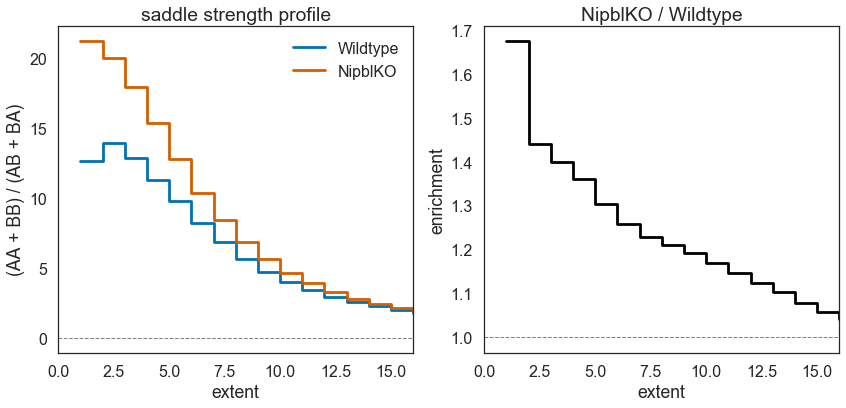

In [60]:
strength = {
    cond: saddle.saddle_strength(sums[cond], counts[cond]) 
        for cond in conditions
}

gs = plt.GridSpec(nrows=1, ncols=2)
plt.figure(figsize=(14, 6))

plt.subplot(gs[0])
x = np.arange(histbins + 2)
for cond in conditions:
    plt.step(x[:-1], strength[cond], where='pre', color=colors[cond], label=long_names[cond])

plt.legend()
plt.xlabel('extent')
plt.ylabel('(AA + BB) / (AB + BA)')
plt.title('saddle strength profile')
plt.axhline(0, c='grey', ls='--', lw=1)
plt.xlim(0, len(x)//2)

plt.subplot(gs[1])
plt.step(x[:-1], strength['dN'] / strength['WT'], where='pre', c='k')
plt.axhline(1, c='grey', ls='--', lw=1)
plt.xlim(0, len(x)//2)
plt.xlabel('extent')
plt.ylabel('enrichment')
plt.title('NipblKO / Wildtype')